# Adversarial Attacks using FGSM (Fast Gradient Signed Method)

In [115]:
'''
Listed here are some sources which I heavily used as reference in doing this project:

https://blog.floydhub.com/introduction-to-adversarial-machine-learning/
https://www.youtube.com/watch?v=CIfsB_EYsVI
https://www.tensorflow.org/tutorials/generative/adversarial_fgsm
https://towardsdatascience.com/adversarial-examples-in-deep-learning-be0b08a94953
https://christophm.github.io/interpretable-ml-book/adversarial.html#methods-and-examples
https://github.com/bethgelab/foolbox

'''


'\nListed here are some sources which I heavily used as reference in doing this project:\n\nhttps://blog.floydhub.com/introduction-to-adversarial-machine-learning/\nhttps://www.youtube.com/watch?v=CIfsB_EYsVI\nhttps://www.tensorflow.org/tutorials/generative/adversarial_fgsm\nhttps://towardsdatascience.com/adversarial-examples-in-deep-learning-be0b08a94953\nhttps://christophm.github.io/interpretable-ml-book/adversarial.html#methods-and-examples\nhttps://github.com/bethgelab/foolbox\n\n'

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [107]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top = True, weights="imagenet")
# Model does not need to be trainable since we receive a trained model:
pretrained_model.trainable = False

# ImageNet Labels
decode_pred = tf.keras.applications.mobilenet_v2.decode_predictions

In [108]:
# Helper function to preprocess the image so that it can be input into our pretrained model (MovileNetV2):
def preprocess (image):
    image = tf.cast(image, tf.float32)
    image /= 255
    image = tf.image.resize(image, (224, 224))
    image = image[None, ...]
    return image

# Helper function to extract labels from probability vector
def get_imagenet_label (probs):
    return decode_pred(probs, top=1)[0][0]

In [109]:
# List of images and we select which one we want to use to create an adversarial example to conduct an attack:
images = []
# 0: Skyscraper:
images.append(["skyscraper.jpg", "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/HK-2IFC-sj_cropped.jpg/440px-HK-2IFC-sj_cropped.jpg"])
# 1: Street Sign:
images.append(["street_sign.jpg", "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f9/STOP_sign.jpg/440px-STOP_sign.jpg"])
# 2: House:
images.append(["house.jpg", "https://compote.slate.com/images/a05dacfb-7c9f-41c5-badd-e462d2516e21.jpeg?width=780&height=520&rect=1560x1040&offset=0x0.jpg"])

index = 1

# Get a the particular image_path
image_path = tf.keras.utils.get_file(images[index][0], images[index][1])
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

<Figure size 864x720 with 0 Axes>

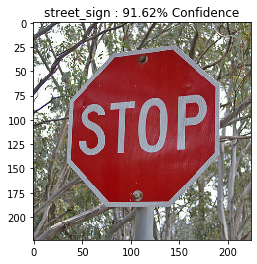

<Figure size 864x720 with 0 Axes>

In [110]:
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.figure(figsize=(12, 10))

In [111]:
# Now we create an Adversarial Image:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1000


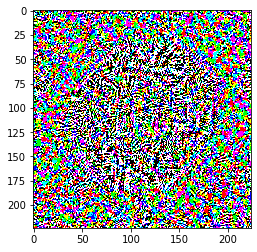

In [112]:
# Get the input label of the image.
image_index = 300
print(image_probs.shape[-1])
label = tf.one_hot(image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

noise = create_adversarial_pattern(image, label)
plt.imshow(noise[0])

In [113]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0])
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
  plt.show()

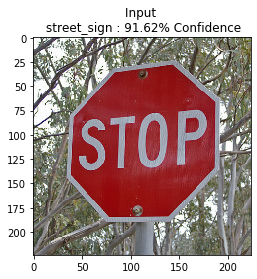

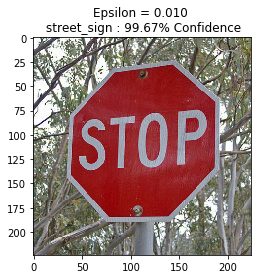

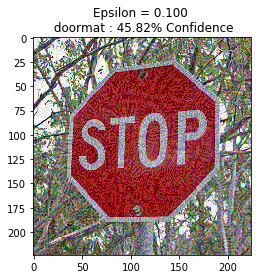

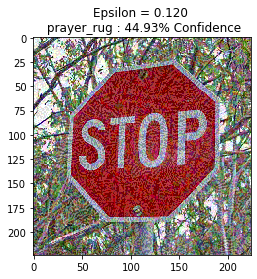

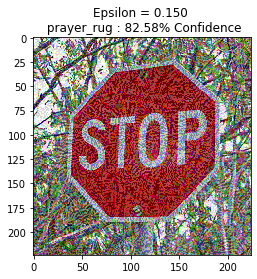

In [114]:
epsilons = [0, 0.01, 0.1, 0.12, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*noise
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  display_images(adv_x, descriptions[i])